<a href="https://colab.research.google.com/github/Miklneuro/Chemikal_kursovaya_work/blob/main/%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_IC50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install numpy==1.26.4 --no-cache-dir > /dev/null
!pip install xgboost optuna scikit-learn pandas matplotlib lightautoml > /dev/null



import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task

# Optuna
import optuna

# Google Colab
from google.colab import drive

import joblib

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MIFI_kurs_chemickal_data/processed_data.csv')

In [ ]:
data.columns


Index(['IC50, mM', 'CC50, mM', 'SI', 'SMR_VSA10_scaled', 'fr_Al_COO_scaled',
       'fr_Al_OH_scaled', 'fr_Al_OH_noTert_scaled', 'fr_ArN_scaled',
       'fr_Ar_COO_scaled', 'fr_Ar_N_scaled',
       ...
       'BCUT2D_MWLOW_sqrt_scaled', 'BCUT2D_CHGHI_sqrt_scaled',
       'BCUT2D_CHGLO_sqrt_scaled', 'BCUT2D_LOGPHI_sqrt_scaled',
       'BCUT2D_LOGPLOW_sqrt_scaled', 'BCUT2D_MRHI_sqrt_scaled',
       'BCUT2D_MRLOW_sqrt_scaled', 'AvgIpc_sqrt_scaled',
       'BalabanJ_sqrt_scaled', 'HallKierAlpha_sqrt_scaled'],
      dtype='object', length=188)

In [ ]:
X = data.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])

In [ ]:
y = data['IC50, mM']

In [ ]:
# Разделение данных на обучающую и тестовую выборки (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Разделение на train/test завершено.")

Разделение на train/test завершено.


Для  дальнейшей работы определимся с пакетом метрик


| Метрика | Описание | Зачем нужна |
|--------|----------|-------------|
| **RMSE** (Root Mean Squared Error) | Среднеквадратичное отклонение предсказанных значений от реальных | Позволяет оценить точность модели с акцентом на большие ошибки; полезна, когда критично минимизировать крупные отклонения в прогнозе активности вещества |
| **MAE** (Mean Absolute Error) | Среднее абсолютное отклонение предсказаний от истинных значений | Даёт интуитивно понятную меру средней ошибки модели; устойчива к выбросам и удобна для интерпретации |
| **R²** (Коэффициент детерминации) | Доля дисперсии целевой переменной, объяснённой моделью | Показывает, насколько хорошо модель воспроизводит вариации в данных; позволяет сравнить модель с тривиальным предсказанием среднего значения |

Проведём моделирование с целью выбора оптимальной, с нашей точки зрения, системы подбора гиперпараметров. Будем исследовать возможности GridSearchCV и Optuna по скорости работы и достигаемым результатам на одинаковых моделях

| Модель | Особенности | Преимущества | Параметры для подбора |
|--------|-------------|--------------|------------------------|
| **Linear Regression** | Простая линейная модель, предполагает линейную зависимость между признаками и целевой переменной | Быстрая, интерпретируемая, хороша как базовая модель | `fit_intercept`, `normalize` (опционально), `alpha` (если используется Ridge/Lasso) |
| **Random Forest Regressor** | Ансамблевая модель на основе множества деревьев, устойчива к переобучению | Хорошо работает "из коробки", оценивает важность признаков | `n_estimators`, `max_depth`, `min_samples_split`, `max_features` |
| **Gradient Boosting Regressor** | Последовательное построение моделей с корректировкой ошибок | Высокая точность прогноза, гибкость | `learning_rate`, `n_estimators`, `max_depth`, `subsample` |
| **Support Vector Regressor (SVR)** | Работает в условиях сложных нелинейных зависимостей | Хорош при малом числе признаков | `C`, `epsilon`, `kernel`, `gamma` |
| **KNeighbors Regressor** | Непараметрический метод, основанный на ближайших соседях | Прост в понимании, не требует обучения | `n_neighbors`, `weights`, `p` (метрика расстояния) |
| **XGBoost Regressor** | Реализация градиентного бустинга с оптимизацией скорости и памяти | Очень высокая эффективность, поддерживает регуляризацию | `learning_rate`, `max_depth`, `n_estimators`, `subsample`, `colsample_bytree` |

In [ ]:
# Словарь моделей с настраиваемыми гиперпараметрами
model_params = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.2],
            'kernel': ['linear', 'rbf']
        }
    },
    'KNeighbors': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, eval_metric='logloss'),
        'params': {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'n_estimators': [50, 100, 200],
            'subsample': [0.8, 1.0]
        }
    }
}

In [ ]:
# Функция вычисления основных метрик
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}

In [ ]:
# Функция запуска с замером времени
def run_and_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    duration = time.time() - start
    return result, duration

###Этап I: Базовое обучение моделей без подбора гиперпараметров

Для проведения дальнейшей оценки и сравнения методов настройки гиперпараметров, необходимо установить базовый уровень качества каждой модели без их подбора. Это позволит понять, насколько каждый метод (GridSearchCV и Optuna) улучшает предсказательную способность моделей по сравнению с начальным состоянием.  

In [ ]:
results_baseline = []

for model_name, config in model_params.items():
    model = config['model']

    # Обучение
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Оценка
    metrics = evaluate_model(y_test, y_pred)

    # Сохраняем результаты
    results_baseline.append({
        'Model': model_name,
        'Params': 'default',
        'Approach': 'Baseline',
        'Time': '-',  # Не замеряем на этом этапе
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'R²': metrics['R²']
    })

# Вывод таблицы с результатами
pd.DataFrame(results_baseline)

,Model,Params,Approach,Time,RMSE,MAE,R²
0,LinearRegression,default,Baseline,-,253.565848,168.921868,-0.182031
1,RandomForest,default,Baseline,-,218.106676,140.291133,0.125449
2,GradientBoosting,default,Baseline,-,219.763929,140.942137,0.112108
3,SVR,default,Baseline,-,256.141315,127.734785,-0.206164
4,KNeighbors,default,Baseline,-,230.624306,140.264934,0.022184
5,XGBoost,default,Baseline,-,242.356968,151.975359,-0.079837


 Вывод по базовому уровню моделей (без подбора гиперпараметров)

Анализ показал, что модели в режиме "по умолчанию" демонстрируют разный уровень прогнозирующей способности , но большинство из них пока не обеспечивает высокой точности.


### Этап II обучение моделей  при  помоши GridSearchCV
*Здесь следует сделать оговорку, что модель линейной регрессии не требует подбора гиперпараметров , поскольку она не имеет настраиваемых параметров вне обучения по методу наименьших квадратов. Эта модель будет использоваться как базовый уровень  для определения прогресса других, более сложных моделей.*

In [ ]:
results_grid = []

for model_name, config in model_params.items():
    if not config['params']:  # Пропускаем LinearRegression
        continue

    model = config['model']
    params = config['params']

    gs = GridSearchCV(model, params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)

    result, duration = run_and_time(gs.fit, X_train, y_train)

    best_model = result.best_estimator_
    y_pred = best_model.predict(X_test)

    metrics = evaluate_model(y_test, y_pred)

    results_grid.append({
        'Model': model_name,
        'Params': result.best_params_,
        'Approach': 'GridSearchCV',
        'Time': round(duration, 2),
        **metrics
    })

# Вывод
pd.DataFrame(results_grid)

,Model,Params,Approach,Time,RMSE,MAE,R²
0,RandomForest,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",GridSearchCV,177.58,217.892849,144.080745,0.127163
1,GradientBoosting,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",GridSearchCV,201.64,219.292766,146.754596,0.115911
2,SVR,"{'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}",GridSearchCV,5.81,232.644343,129.826904,0.004979
3,KNeighbors,"{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",GridSearchCV,0.83,224.690841,137.205076,0.071851
4,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",GridSearchCV,224.81,217.728497,143.404539,0.128479


Выводы:

    Лучшие модели : RandomForest и XGBoost показали наиболее стабильные результаты.
    Сравнение по времени :
        KNeighbors и SVR работают очень быстро, но дают худшее качество.
        RandomForest, XGBoost и GradientBoosting требуют больше времени, но обеспечивают лучший прогноз.
         
    Нужно сравнение с Optuna , чтобы понять:
        позволяет ли он достичь тех же/лучших метрик за меньшее время?
        какие параметры действительно важны?
         
     

### Этап III Обучение  моделей  при помоши  Optuna — байесовская оптимизация

Optuna  — это фреймворк для автоматической оптимизации гиперпараметров, основанный на байесовских методах  и использующий стратегию TPE (Tree-structured Parzen Estimator) .
 Как работает Optuna:

    В отличие от GridSearchCV, который перебирает все возможные комбинации параметров,
    Optuna "умно" исследует пространство параметров , выбирая наиболее перспективные направления поиска.
    На каждой итерации (trial) он учится на предыдущих результатах и исключает заведомо слабые комбинации.
    Это позволяет достигать хороших результатов за меньшее время , особенно при большом числе настраиваемых параметров.
     

 Преимущества Optuna:

    Не требует полного перебора
    Гибкая настройка диапазонов параметров
    Поддерживает early-stopping (прерывание плохих trial-ов)
    Работает с любыми моделями машинного обучения
     

PE (Tree-structured Parzen Estimator) — это алгоритм, который строит две вероятностные модели:

    ℓ(x) — распределение гиперпараметров для успешных  запусков (с низкой ошибкой)
    g(x) — распределение гиперпараметров для неуспешных  запусков
     

На каждой итерации Optuna выбирает такие гиперпараметры x, которые максимизируют отношение:
$$
\text{score}(x) = \frac{\ell(x)}{g(x)}
$$​

То есть, он ищет такие параметры, которые чаще встречались у хороших моделей , и редко — у плохих.   Тким образом алгоритм использует  статичтику  предыдущих  попыток

In [ ]:
results_optuna = []

def objective(trial, model_name):
    model_config = model_params[model_name]
    model_class = type(model_config['model'])
    params_space = model_config['params']

    # Подбираем параметры
    params = {}
    for param_name, values in params_space.items():
        if isinstance(values, list):
            if all(isinstance(v, int) for v in values):
                params[param_name] = trial.suggest_categorical(param_name, values)
            elif all(isinstance(v, float) for v in values):
                params[param_name] = trial.suggest_float(param_name, min(values), max(values))
            else:
                params[param_name] = trial.suggest_categorical(param_name, values)
        elif isinstance(values, tuple):
            if all(isinstance(v, int) for v in values):
                params[param_name] = trial.suggest_int(param_name, *values)
            elif all(isinstance(v, float) for v in values):
                params[param_name] = trial.suggest_float(param_name, *values)

    # Создаём модель
    model = model_class(**params, random_state=42) if 'random_state' in model_class().get_params() else model_class(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Используем уже готовую функцию для подсчёта метрик
    metrics = evaluate_model(y_test, y_pred)

    return metrics['RMSE']  # Оптимизация по RMSE

# Запуск Optuna для каждой модели
for model_name, config in model_params.items():
    if not config['params']:  # Пропускаем LinearRegression
        continue

    print(f"Запуск Optuna для {model_name}...")

    study = optuna.create_study(direction='minimize')
    func = lambda trial, mn=model_name: objective(trial, mn)

    # Замеряем время
    start_time = time.time()
    study.optimize(func, n_trials=30, n_jobs=1, show_progress_bar=True)
    duration = time.time() - start_time

    # Обучаем финальную модель с лучшими параметрами
    best_params = study.best_params
    model_class = type(config['model'])
    model = model_class(**best_params, random_state=42) if 'random_state' in model_class().get_params() else model_class(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = evaluate_model(y_test, y_pred)

    # Сохраняем результаты
    results_optuna.append({
        'Model': model_name,
        'Params': best_params,
        'Approach': 'Optuna',
        'Time': round(duration, 2),
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'R²': metrics['R²']
    })

# Вывод таблицы с результатами
pd.DataFrame(results_optuna)

[I 2025-05-13 09:42:27,127] A new study created in memory with name: no-name-9cdef8d2-6a6d-4af2-817a-8bb158dd68e2


Запуск Optuna для RandomForest...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-13 09:42:29,431] Trial 0 finished with value: 218.07169173000446 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 218.07169173000446.
[I 2025-05-13 09:42:32,373] Trial 1 finished with value: 218.1196409141292 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 0 with value: 218.07169173000446.
[I 2025-05-13 09:42:48,882] Trial 2 finished with value: 217.07329243506126 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}. Best is trial 2 with value: 217.07329243506126.
[I 2025-05-13 09:42:53,861] Trial 3 finished with value: 216.9296432987146 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 3 with value: 216.9296432987146.
[I 2025-05-13 09:43:08,264] Trial 4 finished with value: 217.90043688446656 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}. Best is trial 3 with value: 21

[I 2025-05-13 09:46:38,085] A new study created in memory with name: no-name-a04964ca-9687-438e-9608-5774eefa780e


Запуск Optuna для GradientBoosting...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-13 09:46:39,273] Trial 0 finished with value: 220.10248071990696 and parameters: {'learning_rate': 0.048595091758306945, 'n_estimators': 50, 'max_depth': 3}. Best is trial 0 with value: 220.10248071990696.
[I 2025-05-13 09:46:40,435] Trial 1 finished with value: 217.46332605832458 and parameters: {'learning_rate': 0.10736500903869574, 'n_estimators': 50, 'max_depth': 3}. Best is trial 1 with value: 217.46332605832458.
[I 2025-05-13 09:46:46,036] Trial 2 finished with value: 236.65101055535507 and parameters: {'learning_rate': 0.0677957224100187, 'n_estimators': 100, 'max_depth': 7}. Best is trial 1 with value: 217.46332605832458.
[I 2025-05-13 09:46:47,603] Trial 3 finished with value: 230.7573015128935 and parameters: {'learning_rate': 0.196876944354923, 'n_estimators': 50, 'max_depth': 3}. Best is trial 1 with value: 217.46332605832458.
[I 2025-05-13 09:46:58,349] Trial 4 finished with value: 236.04058412970528 and parameters: {'learning_rate': 0.07310073111824159, 'n_esti

[I 2025-05-13 09:48:02,815] A new study created in memory with name: no-name-91958162-b53a-4f6a-9b4a-de942cb114c0


Запуск Optuna для SVR...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-13 09:48:02,946] Trial 0 finished with value: 241.1448677186458 and parameters: {'C': 1, 'epsilon': 0.11153912217798384, 'kernel': 'linear'}. Best is trial 0 with value: 241.1448677186458.
[I 2025-05-13 09:48:03,071] Trial 1 finished with value: 256.15253903271855 and parameters: {'C': 1, 'epsilon': 0.19676038012520528, 'kernel': 'rbf'}. Best is trial 0 with value: 241.1448677186458.
[I 2025-05-13 09:48:03,195] Trial 2 finished with value: 249.06691205784844 and parameters: {'C': 10, 'epsilon': 0.1700862189895488, 'kernel': 'rbf'}. Best is trial 0 with value: 241.1448677186458.
[I 2025-05-13 09:48:03,308] Trial 3 finished with value: 241.13786605764747 and parameters: {'C': 1, 'epsilon': 0.13585013500790014, 'kernel': 'linear'}. Best is trial 3 with value: 241.13786605764747.
[I 2025-05-13 09:48:03,755] Trial 4 finished with value: 232.6510807151565 and parameters: {'C': 10, 'epsilon': 0.16094514257681192, 'kernel': 'linear'}. Best is trial 4 with value: 232.6510807151565.
[

[I 2025-05-13 09:48:15,515] A new study created in memory with name: no-name-fd52f417-61b0-45aa-9d61-593a079b1aae


Запуск Optuna для KNeighbors...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-13 09:48:15,551] Trial 0 finished with value: 230.62430640398094 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 230.62430640398094.
[I 2025-05-13 09:48:15,566] Trial 1 finished with value: 226.64824722310732 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 226.64824722310732.
[I 2025-05-13 09:48:15,583] Trial 2 finished with value: 226.64824722310732 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 226.64824722310732.
[I 2025-05-13 09:48:15,602] Trial 3 finished with value: 231.30415442783 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 226.64824722310732.
[I 2025-05-13 09:48:15,658] Trial 4 finished with value: 232.95266862135844 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 226.64824722310732.
[I 2025-05-13 09:48:15,679] Trial 5 finished with v

[I 2025-05-13 09:48:17,047] A new study created in memory with name: no-name-5d31dfbb-d8bc-496e-b869-ea8cdf97813a


[I 2025-05-13 09:48:16,934] Trial 28 finished with value: 227.51405488690207 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 26 with value: 221.9843728275776.
[I 2025-05-13 09:48:16,986] Trial 29 finished with value: 224.69084095485948 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 26 with value: 221.9843728275776.
Запуск Optuna для XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-05-13 09:48:17,626] Trial 0 finished with value: 217.91870138188625 and parameters: {'learning_rate': 0.09456697816680996, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8081240428353174}. Best is trial 0 with value: 217.91870138188625.
[I 2025-05-13 09:48:18,377] Trial 1 finished with value: 216.03769662866844 and parameters: {'learning_rate': 0.019148082811739076, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8976535968587642}. Best is trial 1 with value: 216.03769662866844.
[I 2025-05-13 09:48:18,954] Trial 2 finished with value: 217.60131602616852 and parameters: {'learning_rate': 0.06564931355729389, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9854688716833389}. Best is trial 1 with value: 216.03769662866844.
[I 2025-05-13 09:48:25,778] Trial 3 finished with value: 217.7757101719483 and parameters: {'learning_rate': 0.04001357837598256, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8314546254186508}. Best is trial 1 with value: 216.03769662866844.
[

,Model,Params,Approach,Time,RMSE,MAE,R²
0,RandomForest,"{'n_estimators': 200, 'max_depth': 10, 'min_sa...",Optuna,240.73,215.862792,141.829151,0.143351
1,GradientBoosting,"{'learning_rate': 0.10736500903869574, 'n_esti...",Optuna,83.56,217.463326,142.842768,0.130601
2,SVR,"{'C': 10, 'epsilon': 0.10001788537603798, 'ker...",Optuna,12.08,232.644352,129.826907,0.004979
3,KNeighbors,"{'n_neighbors': 5, 'weights': 'uniform', 'p': 1}",Optuna,1.47,221.984373,133.854239,0.094076
4,XGBoost,"{'learning_rate': 0.07281884214361883, 'max_de...",Optuna,42.36,212.310020,131.589829,0.171318


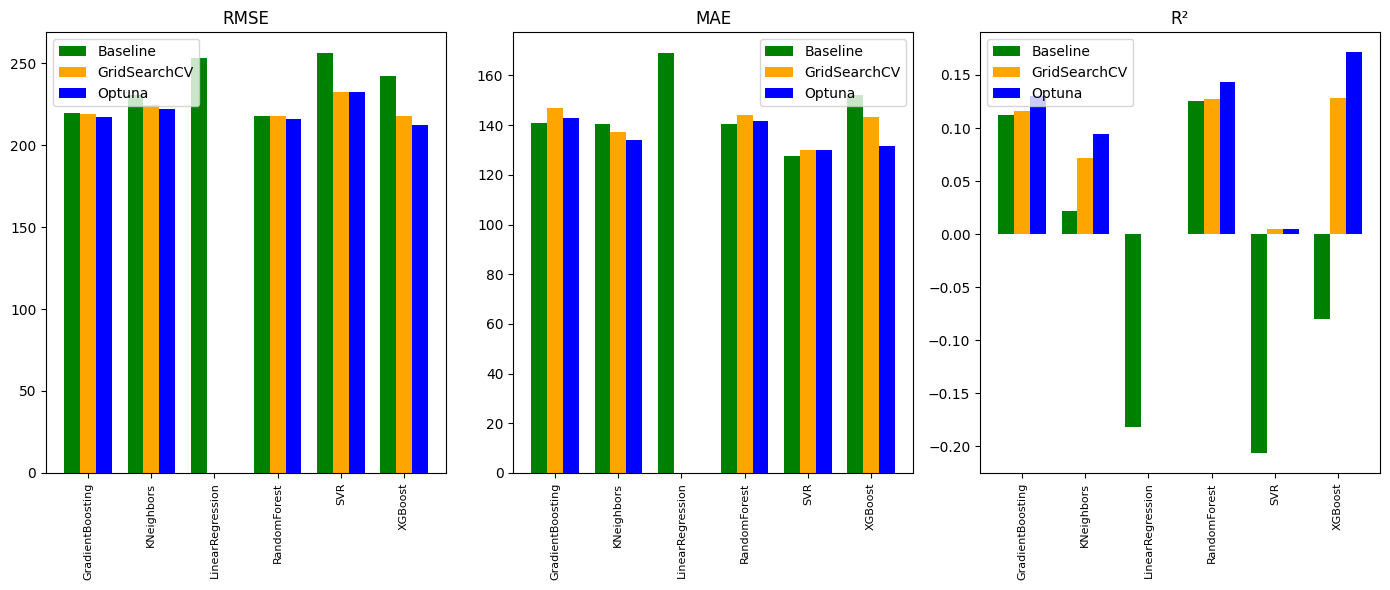

In [ ]:
# Объединяем все результаты
all_results = pd.concat([
    pd.DataFrame(results_baseline),
    pd.DataFrame(results_grid),
    pd.DataFrame(results_optuna)
], ignore_index=True)

# Делаем сводную таблицу только по числовым метрикам
pivot_results = all_results.pivot_table(
    index='Model',
    columns='Approach',
    values=['RMSE', 'MAE', 'R²']
)

# Получаем список моделей и подходов
models = pivot_results.index.tolist()
approaches = ['Baseline', 'GridSearchCV', 'Optuna']

# Цвета для каждого подхода
colors = {
    'Baseline': 'green',
    'GridSearchCV': 'orange',
    'Optuna': 'blue'
}

bar_width = 0.25
x = np.arange(len(models))

# Визуализируем
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 3, 1)
for i, approach in enumerate(approaches):
    values = pivot_results['RMSE'][approach].values
    plt.bar(x + bar_width * (i - 1), values, width=bar_width, label=approach, color=colors[approach])
plt.title('RMSE')
plt.xticks(x, models, rotation=90, fontsize=8)
plt.legend()

# MAE
plt.subplot(1, 3, 2)
for i, approach in enumerate(approaches):
    values = pivot_results['MAE'][approach].values
    plt.bar(x + bar_width * (i - 1), values, width=bar_width, label=approach, color=colors[approach])
plt.title('MAE')
plt.xticks(x, models, rotation=90, fontsize=8)
plt.legend()

# R²
plt.subplot(1, 3, 3)
for i, approach in enumerate(approaches):
    values = pivot_results['R²'][approach].values
    plt.bar(x + bar_width * (i - 1), values, width=bar_width, label=approach, color=colors[approach])
plt.title('R²')
plt.xticks(x, models, rotation=90, fontsize=8)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Объединяем все результаты в один DataFrame
all_results = pd.concat([
    pd.DataFrame(results_baseline),
    pd.DataFrame(results_grid),
    pd.DataFrame(results_optuna)
], ignore_index=True)

# Делаем сводную таблицу: модель + подход -> метрики
pivot_table = all_results.pivot_table(
    index='Model',
    columns='Approach',
    values=['RMSE', 'MAE', 'R²']
)

# Меняем названия столбцов для удобства
pivot_table.columns = [f"{metric}_{approach}" for metric, approach in pivot_table.columns]

# Сброс индекса для удобства
pivot_table.reset_index(inplace=True)

# Вывод таблицы
print(" Сравнение моделей по метрикам:")
pivot_table.head(len(pivot_table))

 Сравнение моделей по метрикам:


,Model,MAE_Baseline,MAE_GridSearchCV,MAE_Optuna,RMSE_Baseline,RMSE_GridSearchCV,RMSE_Optuna,R²_Baseline,R²_GridSearchCV,R²_Optuna
0,GradientBoosting,140.942137,146.754596,142.842768,219.763929,219.292766,217.463326,0.112108,0.115911,0.130601
1,KNeighbors,140.264934,137.205076,133.854239,230.624306,224.690841,221.984373,0.022184,0.071851,0.094076
2,LinearRegression,168.921868,NaN,NaN,253.565848,NaN,NaN,-0.182031,NaN,NaN
3,RandomForest,140.291133,144.080745,141.829151,218.106676,217.892849,215.862792,0.125449,0.127163,0.143351
4,SVR,127.734785,129.826904,129.826907,256.141315,232.644343,232.644352,-0.206164,0.004979,0.004979
5,XGBoost,151.975359,143.404539,131.589829,242.356968,217.728497,212.310020,-0.079837,0.128479,0.171318


Ключевые наблюдения

1. Optuna показывает лучшие результаты

Для большинства моделей (XGBoost, RandomForest, GradientBoosting) метод Optuna даёт наибольшее значение R² и наименьшие значения RMSE/MAE.

Особенно заметный прогресс у модели XGBoost:

    R² вырос с -0.08 (Baseline) до 0.171 (Optuna) — это значительное улучшение, особенно если учитывать, что ранее модель
    не объясняла данные лучше константного предсказания.

Тем не менее, стоит отметить:

    Значение R² = 0.171, хотя и является лучшим среди всех протестированных моделей, всё ещё говорит о том, что модель
    объясняет лишь около 17% дисперсии целевой переменной.
    Это может указывать как на ограничения в данных, так и на
    сложность самой задачи прогнозирования IC50.

2. GridSearchCV работает не хуже, но и не лучше Optuna

В некоторых случаях (например, RandomForest) он показывает сопоставимые с Optuna результаты. Однако в среднем Optuna позволяет достигать лучших метрик за меньшее число итераций, что делает его более эффективным инструментом подбора гиперпараметров.

3. Baseline иногда близок к оптимальному

Для моделей SVR и KNeighbors подбор гиперпараметров не привёл к существенному улучшению качества. Это может говорить о следующем:

    Либо данные имеют низкую информативность признаков,

    Либо модель уже была достаточно устойчивой и адаптированной "из коробки".

4. Некоторые модели работают стабильно хуже других

Модели LinearRegression и SVR показывают низкое качество прогноза, особенно по метрике R². Эти модели, видимо, недостаточно подходят для данной задачи без дополнительной работы над признаками или преобразования данных.

Лучшая модель: XGBoost

    Наилучший показатель объяснённой дисперсии: R² = 0.171

    Причина успеха: ансамблевый метод с возможностью регуляризации и эффективной оптимизации

Лучший метод настройки: Optuna

    Обеспечивает либо сравнимую, либо лучшую производительность по сравнению с GridSearchCV

    Работает быстрее, чем полный перебор

    Позволяет находить более тонкие комбинации параметров

Важно:
Хотя R² = 0.171 является лучшим результатом среди всех моделей, оно не является высоким в абсолютном смысле. Такое значение говорит о том, что модель объясняет лишь около 17% вариации целевой переменной, что может быть недостаточно для точного прогноза в практическом применении.

Второй вариант: RandomForest

    Более простая и интерпретируемая модель

    Хорошо себя показала как с GridSearchCV, так и с Optuna

##Итоговый вывод

  Исследование показало, что наилучшее качество прогнозирования IC50 достигается при использовании модели XGBoost с гиперпараметрами, подобранными с помощью Optuna .
  Полученная модель демонстрирует R² = 0.171 , что является наилучшим результатом среди всех исследованных моделей и методов настройки .
     

 Однако, следует учитывать, что:

  Значение R² = 0.171  свидетельствует о умеренной способности модели объяснять вариацию целевой переменной . Это может говорить как о сложности самой задачи, так и о необходимости дальнейшей работы над качеством признаков, их преобразованием или расширением.
     

Проведем  логарифмирование целевой переменной

In [ ]:
# Логарифмируем целевую переменную
y_log = np.log1p(data['IC50, mM'])  # log(1 + IC50)
X = data.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print("✅ Целевая переменная логарифмирована и данные разделены")

✅ Целевая переменная логарифмирована и данные разделены


In [ ]:
results_optuna_log = []

def objective_log(trial, model_name):
    model_config = model_params[model_name]
    model_class = type(model_config['model'])
    params_space = model_config['params']

    # Подбираем параметры
    params = {}
    for param_name, values in params_space.items():
        if isinstance(values, list):
            if all(isinstance(v, int) for v in values):
                params[param_name] = trial.suggest_categorical(param_name, values)
            elif all(isinstance(v, float) for v in values):
                params[param_name] = trial.suggest_float(param_name, min(values), max(values))
            else:
                params[param_name] = trial.suggest_categorical(param_name, values)
        elif isinstance(values, tuple):
            if all(isinstance(v, int) for v in values):
                params[param_name] = trial.suggest_int(param_name, *values)
            elif all(isinstance(v, float) for v in values):
                params[param_name] = trial.suggest_float(param_name, *values)

    # Создаём модель
    model = model_class(**params, random_state=42) if 'random_state' in model_class().get_params() else model_class(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Используем уже готовую функцию оценки
    metrics = evaluate_model(y_test, y_pred)

    return metrics['RMSE']  # Оптимизация по RMSE

In [ ]:
for model_name, config in model_params.items():
    if not config['params']:  # Пропускаем LinearRegression
        continue

    print(f" Запуск Optuna для {model_name} с log(IC50)...")

    study = optuna.create_study(direction='minimize')
    func = lambda trial, mn=model_name: objective_log(trial, mn)

    # Замеряем время
    start_time = time.time()
    study.optimize(func, n_trials=30, n_jobs=1, show_progress_bar=True)
    duration = time.time() - start_time

    # Обучаем финальную модель с лучшими параметрами
    best_params = study.best_params
    model_class = type(config['model'])
    model = model_class(**best_params, random_state=42) if 'random_state' in model_class().get_params() else model_class(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = evaluate_model(y_test, y_pred)

    # Сохраняем результаты
    results_optuna_log.append({
        'Model': model_name,
        'Params': best_params,
        'Approach': 'Optuna (log)',
        'Time': round(duration, 2),
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'R²': metrics['R²']
    })

# Вывод таблицы
optuna_log_df = pd.DataFrame(results_optuna_log)
optuna_log_df.sort_values(by='R²', ascending=False, inplace=True)
optuna_log_df.reset_index(drop=True, inplace=True)
optuna_log_df

[I 2025-05-13 12:21:50,835] A new study created in memory with name: no-name-986dd6ee-1c7a-4fc0-9187-f6ee6033309f
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-986dd6ee-1c7a-4fc0-9187-f6ee6033309f


 Запуск Optuna для RandomForest с log(IC50)...


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:optuna.study.study:Trial 0 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:21:53,591] Trial 0 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 1 finished with value: 1.3952864659970814 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:21:54,825] Trial 1 finished with value: 1.3952864659970814 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 2 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:21:57,041] Trial 2 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 3 finished with value: 1.3801165105234943 and parameters: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:21:59,521] Trial 3 finished with value: 1.3801165105234943 and parameters: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 4 finished with value: 1.3953884491619184 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:10,457] Trial 4 finished with value: 1.3953884491619184 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 5 finished with value: 1.3952864659970814 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:11,696] Trial 5 finished with value: 1.3952864659970814 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 6 finished with value: 1.3973217852079425 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:16,633] Trial 6 finished with value: 1.3973217852079425 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 7 finished with value: 1.3932119213918783 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:22,608] Trial 7 finished with value: 1.3932119213918783 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 8 finished with value: 1.398886291302833 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:34,893] Trial 8 finished with value: 1.398886291302833 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 9 finished with value: 1.3871565557814154 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:39,429] Trial 9 finished with value: 1.3871565557814154 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 10 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:41,656] Trial 10 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 11 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:43,881] Trial 11 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 12 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:46,455] Trial 12 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 13 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:49,447] Trial 13 finished with value: 1.3776442378087042 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 14 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:51,565] Trial 14 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 15 finished with value: 1.3825571600756663 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:55,726] Trial 15 finished with value: 1.3825571600756663 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 16 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:22:57,817] Trial 16 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 17 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:00,112] Trial 17 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 18 finished with value: 1.3825571600756663 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:05,150] Trial 18 finished with value: 1.3825571600756663 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 19 finished with value: 1.3973217852079425 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:10,051] Trial 19 finished with value: 1.3973217852079425 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 20 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:12,145] Trial 20 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 21 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:14,587] Trial 21 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 22 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:17,458] Trial 22 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 23 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:19,554] Trial 23 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 24 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:21,669] Trial 24 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 25 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:23,762] Trial 25 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 26 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:25,870] Trial 26 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 27 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:28,174] Trial 27 finished with value: 1.3761654646840682 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 28 finished with value: 1.3932119213918783 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:33,986] Trial 28 finished with value: 1.3932119213918783 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


INFO:optuna.study.study:Trial 29 finished with value: 1.3973217852079425 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:38,895] Trial 29 finished with value: 1.3973217852079425 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 1.3761654646840682.


[I 2025-05-13 12:23:40,999] A new study created in memory with name: no-name-52fba235-9c23-4737-863c-2033f512fdd8
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-52fba235-9c23-4737-863c-2033f512fdd8


 Запуск Optuna для GradientBoosting с log(IC50)...


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:optuna.study.study:Trial 0 finished with value: 1.4033373151792943 and parameters: {'learning_rate': 0.036662752706680485, 'n_estimators': 50, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:23:42,445] Trial 0 finished with value: 1.4033373151792943 and parameters: {'learning_rate': 0.036662752706680485, 'n_estimators': 50, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 1 finished with value: 1.4716088974732544 and parameters: {'learning_rate': 0.03556308992914039, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:23:53,508] Trial 1 finished with value: 1.4716088974732544 and parameters: {'learning_rate': 0.03556308992914039, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 2 finished with value: 1.5333074284822066 and parameters: {'learning_rate': 0.1749804877285382, 'n_estimators': 200, 'max_depth': 5}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:02,103] Trial 2 finished with value: 1.5333074284822066 and parameters: {'learning_rate': 0.1749804877285382, 'n_estimators': 200, 'max_depth': 5}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 3 finished with value: 1.405280046802389 and parameters: {'learning_rate': 0.03697973050227492, 'n_estimators': 50, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:04,637] Trial 3 finished with value: 1.405280046802389 and parameters: {'learning_rate': 0.03697973050227492, 'n_estimators': 50, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 4 finished with value: 1.518695689201002 and parameters: {'learning_rate': 0.07061362680209622, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:15,948] Trial 4 finished with value: 1.518695689201002 and parameters: {'learning_rate': 0.07061362680209622, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 5 finished with value: 1.4657474773819472 and parameters: {'learning_rate': 0.1530280319297586, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:27,274] Trial 5 finished with value: 1.4657474773819472 and parameters: {'learning_rate': 0.1530280319297586, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 6 finished with value: 1.4994545672312891 and parameters: {'learning_rate': 0.1906211508702065, 'n_estimators': 200, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:31,993] Trial 6 finished with value: 1.4994545672312891 and parameters: {'learning_rate': 0.1906211508702065, 'n_estimators': 200, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 7 finished with value: 1.431794692683689 and parameters: {'learning_rate': 0.15096469017828312, 'n_estimators': 50, 'max_depth': 5}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:33,891] Trial 7 finished with value: 1.431794692683689 and parameters: {'learning_rate': 0.15096469017828312, 'n_estimators': 50, 'max_depth': 5}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 8 finished with value: 1.4895191228210434 and parameters: {'learning_rate': 0.1185213464583198, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:45,305] Trial 8 finished with value: 1.4895191228210434 and parameters: {'learning_rate': 0.1185213464583198, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 9 finished with value: 1.44009191877848 and parameters: {'learning_rate': 0.08215337980893882, 'n_estimators': 100, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:47,646] Trial 9 finished with value: 1.44009191877848 and parameters: {'learning_rate': 0.08215337980893882, 'n_estimators': 100, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 10 finished with value: 1.5222588964496508 and parameters: {'learning_rate': 0.012015241354018824, 'n_estimators': 50, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


[I 2025-05-13 12:24:48,802] Trial 10 finished with value: 1.5222588964496508 and parameters: {'learning_rate': 0.012015241354018824, 'n_estimators': 50, 'max_depth': 3}. Best is trial 0 with value: 1.4033373151792943.


INFO:optuna.study.study:Trial 11 finished with value: 1.3974515050948941 and parameters: {'learning_rate': 0.049983792179172655, 'n_estimators': 50, 'max_depth': 3}. Best is trial 11 with value: 1.3974515050948941.


[I 2025-05-13 12:24:49,964] Trial 11 finished with value: 1.3974515050948941 and parameters: {'learning_rate': 0.049983792179172655, 'n_estimators': 50, 'max_depth': 3}. Best is trial 11 with value: 1.3974515050948941.


INFO:optuna.study.study:Trial 12 finished with value: 1.3971816708142821 and parameters: {'learning_rate': 0.06527711288310709, 'n_estimators': 50, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


[I 2025-05-13 12:24:51,135] Trial 12 finished with value: 1.3971816708142821 and parameters: {'learning_rate': 0.06527711288310709, 'n_estimators': 50, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


INFO:optuna.study.study:Trial 13 finished with value: 1.413497017194799 and parameters: {'learning_rate': 0.08047300553631644, 'n_estimators': 50, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


[I 2025-05-13 12:24:52,608] Trial 13 finished with value: 1.413497017194799 and parameters: {'learning_rate': 0.08047300553631644, 'n_estimators': 50, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


INFO:optuna.study.study:Trial 14 finished with value: 1.4246364925171167 and parameters: {'learning_rate': 0.06007486030348572, 'n_estimators': 100, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


[I 2025-05-13 12:24:55,654] Trial 14 finished with value: 1.4246364925171167 and parameters: {'learning_rate': 0.06007486030348572, 'n_estimators': 100, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


INFO:optuna.study.study:Trial 15 finished with value: 1.4187794350356768 and parameters: {'learning_rate': 0.10740105702158895, 'n_estimators': 50, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


[I 2025-05-13 12:24:56,820] Trial 15 finished with value: 1.4187794350356768 and parameters: {'learning_rate': 0.10740105702158895, 'n_estimators': 50, 'max_depth': 3}. Best is trial 12 with value: 1.3971816708142821.


INFO:optuna.study.study:Trial 16 finished with value: 1.394831465629125 and parameters: {'learning_rate': 0.05738659139805542, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:24:57,983] Trial 16 finished with value: 1.394831465629125 and parameters: {'learning_rate': 0.05738659139805542, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 17 finished with value: 1.4351898048232317 and parameters: {'learning_rate': 0.09384235353883594, 'n_estimators': 50, 'max_depth': 5}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:24:59,848] Trial 17 finished with value: 1.4351898048232317 and parameters: {'learning_rate': 0.09384235353883594, 'n_estimators': 50, 'max_depth': 5}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 18 finished with value: 1.4432941990603094 and parameters: {'learning_rate': 0.011695568540647294, 'n_estimators': 100, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:02,164] Trial 18 finished with value: 1.4432941990603094 and parameters: {'learning_rate': 0.011695568540647294, 'n_estimators': 100, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 19 finished with value: 1.4155610751122698 and parameters: {'learning_rate': 0.12489963013854248, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:03,359] Trial 19 finished with value: 1.4155610751122698 and parameters: {'learning_rate': 0.12489963013854248, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 20 finished with value: 1.4059789520160015 and parameters: {'learning_rate': 0.054273232634742145, 'n_estimators': 50, 'max_depth': 5}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:05,208] Trial 20 finished with value: 1.4059789520160015 and parameters: {'learning_rate': 0.054273232634742145, 'n_estimators': 50, 'max_depth': 5}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 21 finished with value: 1.3982906531059953 and parameters: {'learning_rate': 0.05439476088626135, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:06,704] Trial 21 finished with value: 1.3982906531059953 and parameters: {'learning_rate': 0.05439476088626135, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 22 finished with value: 1.3982129042541194 and parameters: {'learning_rate': 0.038416034359276666, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:08,253] Trial 22 finished with value: 1.3982129042541194 and parameters: {'learning_rate': 0.038416034359276666, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 23 finished with value: 1.4012684004656795 and parameters: {'learning_rate': 0.0681321417191037, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:09,737] Trial 23 finished with value: 1.4012684004656795 and parameters: {'learning_rate': 0.0681321417191037, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 24 finished with value: 1.4020654935206778 and parameters: {'learning_rate': 0.09544308034849305, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:10,926] Trial 24 finished with value: 1.4020654935206778 and parameters: {'learning_rate': 0.09544308034849305, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 25 finished with value: 1.412473518370119 and parameters: {'learning_rate': 0.0490335542789843, 'n_estimators': 100, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:13,267] Trial 25 finished with value: 1.412473518370119 and parameters: {'learning_rate': 0.0490335542789843, 'n_estimators': 100, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 26 finished with value: 1.4648810769236182 and parameters: {'learning_rate': 0.02030727153581206, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:14,441] Trial 26 finished with value: 1.4648810769236182 and parameters: {'learning_rate': 0.02030727153581206, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 27 finished with value: 1.4154646041367736 and parameters: {'learning_rate': 0.08231963244173186, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:15,638] Trial 27 finished with value: 1.4154646041367736 and parameters: {'learning_rate': 0.08231963244173186, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 28 finished with value: 1.4137190379263178 and parameters: {'learning_rate': 0.02754999965503939, 'n_estimators': 50, 'max_depth': 5}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:17,522] Trial 28 finished with value: 1.4137190379263178 and parameters: {'learning_rate': 0.02754999965503939, 'n_estimators': 50, 'max_depth': 5}. Best is trial 16 with value: 1.394831465629125.


INFO:optuna.study.study:Trial 29 finished with value: 1.4042825796664629 and parameters: {'learning_rate': 0.04464061327534947, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:18,706] Trial 29 finished with value: 1.4042825796664629 and parameters: {'learning_rate': 0.04464061327534947, 'n_estimators': 50, 'max_depth': 3}. Best is trial 16 with value: 1.394831465629125.


[I 2025-05-13 12:25:20,022] A new study created in memory with name: no-name-31b3013b-b713-4907-91b6-f1224b549471
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-31b3013b-b713-4907-91b6-f1224b549471


 Запуск Optuna для SVR с log(IC50)...


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:optuna.study.study:Trial 0 finished with value: 1.769281385501266 and parameters: {'C': 1, 'epsilon': 0.1539035192515322, 'kernel': 'linear'}. Best is trial 0 with value: 1.769281385501266.


[I 2025-05-13 12:25:22,427] Trial 0 finished with value: 1.769281385501266 and parameters: {'C': 1, 'epsilon': 0.1539035192515322, 'kernel': 'linear'}. Best is trial 0 with value: 1.769281385501266.


INFO:optuna.study.study:Trial 1 finished with value: 1.7809585566381705 and parameters: {'C': 1, 'epsilon': 0.18392146549440266, 'kernel': 'linear'}. Best is trial 0 with value: 1.769281385501266.
INFO:optuna.study.study:Trial 2 finished with value: 1.5002973582140686 and parameters: {'C': 10, 'epsilon': 0.18591264404505548, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


[I 2025-05-13 12:25:24,509] Trial 1 finished with value: 1.7809585566381705 and parameters: {'C': 1, 'epsilon': 0.18392146549440266, 'kernel': 'linear'}. Best is trial 0 with value: 1.769281385501266.
[I 2025-05-13 12:25:24,646] Trial 2 finished with value: 1.5002973582140686 and parameters: {'C': 10, 'epsilon': 0.18591264404505548, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


INFO:optuna.study.study:Trial 3 finished with value: 1.7704208283988894 and parameters: {'C': 1, 'epsilon': 0.12800784067361892, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.
INFO:optuna.study.study:Trial 4 finished with value: 1.557923846210592 and parameters: {'C': 0.1, 'epsilon': 0.19218157558969973, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


[I 2025-05-13 12:25:26,422] Trial 3 finished with value: 1.7704208283988894 and parameters: {'C': 1, 'epsilon': 0.12800784067361892, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.
[I 2025-05-13 12:25:26,556] Trial 4 finished with value: 1.557923846210592 and parameters: {'C': 0.1, 'epsilon': 0.19218157558969973, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


INFO:optuna.study.study:Trial 5 finished with value: 1.7684981473578483 and parameters: {'C': 1, 'epsilon': 0.12057170391450378, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.
INFO:optuna.study.study:Trial 6 finished with value: 1.5589090475469995 and parameters: {'C': 0.1, 'epsilon': 0.17631432148453108, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


[I 2025-05-13 12:25:27,838] Trial 5 finished with value: 1.7684981473578483 and parameters: {'C': 1, 'epsilon': 0.12057170391450378, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.
[I 2025-05-13 12:25:27,952] Trial 6 finished with value: 1.5589090475469995 and parameters: {'C': 0.1, 'epsilon': 0.17631432148453108, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


INFO:optuna.study.study:Trial 7 finished with value: 1.5590235358274116 and parameters: {'C': 0.1, 'epsilon': 0.1743354666389459, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


[I 2025-05-13 12:25:28,069] Trial 7 finished with value: 1.5590235358274116 and parameters: {'C': 0.1, 'epsilon': 0.1743354666389459, 'kernel': 'rbf'}. Best is trial 2 with value: 1.5002973582140686.


INFO:optuna.study.study:Trial 8 finished with value: 1.7744679110566413 and parameters: {'C': 1, 'epsilon': 0.16272947065097598, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.


[I 2025-05-13 12:25:29,501] Trial 8 finished with value: 1.7744679110566413 and parameters: {'C': 1, 'epsilon': 0.16272947065097598, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.


INFO:optuna.study.study:Trial 9 finished with value: 1.8136577442509711 and parameters: {'C': 10, 'epsilon': 0.13023121242968105, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.


[I 2025-05-13 12:26:02,773] Trial 9 finished with value: 1.8136577442509711 and parameters: {'C': 10, 'epsilon': 0.13023121242968105, 'kernel': 'linear'}. Best is trial 2 with value: 1.5002973582140686.


INFO:optuna.study.study:Trial 10 finished with value: 1.4998014797551602 and parameters: {'C': 10, 'epsilon': 0.19913009819705071, 'kernel': 'rbf'}. Best is trial 10 with value: 1.4998014797551602.


[I 2025-05-13 12:26:03,000] Trial 10 finished with value: 1.4998014797551602 and parameters: {'C': 10, 'epsilon': 0.19913009819705071, 'kernel': 'rbf'}. Best is trial 10 with value: 1.4998014797551602.


INFO:optuna.study.study:Trial 11 finished with value: 1.5000185827882948 and parameters: {'C': 10, 'epsilon': 0.19311459932864639, 'kernel': 'rbf'}. Best is trial 10 with value: 1.4998014797551602.


[I 2025-05-13 12:26:03,233] Trial 11 finished with value: 1.5000185827882948 and parameters: {'C': 10, 'epsilon': 0.19311459932864639, 'kernel': 'rbf'}. Best is trial 10 with value: 1.4998014797551602.


INFO:optuna.study.study:Trial 12 finished with value: 1.4997828390614296 and parameters: {'C': 10, 'epsilon': 0.19939373143431635, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:03,475] Trial 12 finished with value: 1.4997828390614296 and parameters: {'C': 10, 'epsilon': 0.19939373143431635, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 13 finished with value: 1.4998488221344046 and parameters: {'C': 10, 'epsilon': 0.19795340634011058, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:03,691] Trial 13 finished with value: 1.4998488221344046 and parameters: {'C': 10, 'epsilon': 0.19795340634011058, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 14 finished with value: 1.5094676073526287 and parameters: {'C': 10, 'epsilon': 0.10056813039932212, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:03,915] Trial 14 finished with value: 1.5094676073526287 and parameters: {'C': 10, 'epsilon': 0.10056813039932212, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 15 finished with value: 1.5015663904089667 and parameters: {'C': 10, 'epsilon': 0.16592031936950974, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:04,131] Trial 15 finished with value: 1.5015663904089667 and parameters: {'C': 10, 'epsilon': 0.16592031936950974, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 16 finished with value: 1.5031375432618659 and parameters: {'C': 10, 'epsilon': 0.14781365526927326, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:04,382] Trial 16 finished with value: 1.5031375432618659 and parameters: {'C': 10, 'epsilon': 0.14781365526927326, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 17 finished with value: 1.4998112101177747 and parameters: {'C': 10, 'epsilon': 0.19886745833528396, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:04,604] Trial 17 finished with value: 1.4998112101177747 and parameters: {'C': 10, 'epsilon': 0.19886745833528396, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 18 finished with value: 1.5008327216730404 and parameters: {'C': 10, 'epsilon': 0.1766692046207697, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:04,836] Trial 18 finished with value: 1.5008327216730404 and parameters: {'C': 10, 'epsilon': 0.1766692046207697, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 19 finished with value: 1.5033564246584883 and parameters: {'C': 10, 'epsilon': 0.1460331685652325, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.
INFO:optuna.study.study:Trial 20 finished with value: 1.5581822209002834 and parameters: {'C': 0.1, 'epsilon': 0.18669946170453028, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


[I 2025-05-13 12:26:05,073] Trial 19 finished with value: 1.5033564246584883 and parameters: {'C': 10, 'epsilon': 0.1460331685652325, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.
[I 2025-05-13 12:26:05,259] Trial 20 finished with value: 1.5581822209002834 and parameters: {'C': 0.1, 'epsilon': 0.18669946170453028, 'kernel': 'rbf'}. Best is trial 12 with value: 1.4997828390614296.


INFO:optuna.study.study:Trial 21 finished with value: 1.499760217091614 and parameters: {'C': 10, 'epsilon': 0.199921728605941, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


[I 2025-05-13 12:26:05,512] Trial 21 finished with value: 1.499760217091614 and parameters: {'C': 10, 'epsilon': 0.199921728605941, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


INFO:optuna.study.study:Trial 22 finished with value: 1.4998224114984344 and parameters: {'C': 10, 'epsilon': 0.19824346173212362, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.
INFO:optuna.study.study:Trial 23 finished with value: 1.5001729681321256 and parameters: {'C': 10, 'epsilon': 0.18872400167141223, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


[I 2025-05-13 12:26:05,749] Trial 22 finished with value: 1.4998224114984344 and parameters: {'C': 10, 'epsilon': 0.19824346173212362, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.
[I 2025-05-13 12:26:05,903] Trial 23 finished with value: 1.5001729681321256 and parameters: {'C': 10, 'epsilon': 0.18872400167141223, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


INFO:optuna.study.study:Trial 24 finished with value: 1.5006363098792317 and parameters: {'C': 10, 'epsilon': 0.17943281300191014, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.
INFO:optuna.study.study:Trial 25 finished with value: 1.5014500842160838 and parameters: {'C': 10, 'epsilon': 0.1681628903243676, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


[I 2025-05-13 12:26:06,045] Trial 24 finished with value: 1.5006363098792317 and parameters: {'C': 10, 'epsilon': 0.17943281300191014, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.
[I 2025-05-13 12:26:06,185] Trial 25 finished with value: 1.5014500842160838 and parameters: {'C': 10, 'epsilon': 0.1681628903243676, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


INFO:optuna.study.study:Trial 26 finished with value: 1.5000206021714124 and parameters: {'C': 10, 'epsilon': 0.19288729289583928, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.
INFO:optuna.study.study:Trial 27 finished with value: 1.5022752241741684 and parameters: {'C': 10, 'epsilon': 0.15660790940396113, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


[I 2025-05-13 12:26:06,339] Trial 26 finished with value: 1.5000206021714124 and parameters: {'C': 10, 'epsilon': 0.19288729289583928, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.
[I 2025-05-13 12:26:06,492] Trial 27 finished with value: 1.5022752241741684 and parameters: {'C': 10, 'epsilon': 0.15660790940396113, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


INFO:optuna.study.study:Trial 28 finished with value: 1.5585474101133945 and parameters: {'C': 0.1, 'epsilon': 0.18200027033454755, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


[I 2025-05-13 12:26:06,615] Trial 28 finished with value: 1.5585474101133945 and parameters: {'C': 0.1, 'epsilon': 0.18200027033454755, 'kernel': 'rbf'}. Best is trial 21 with value: 1.499760217091614.


INFO:optuna.study.study:Trial 29 finished with value: 1.8142125266335343 and parameters: {'C': 10, 'epsilon': 0.14057670375567954, 'kernel': 'linear'}. Best is trial 21 with value: 1.499760217091614.
[I 2025-05-13 12:26:25,504] A new study created in memory with name: no-name-6c534283-11e6-4fe5-bf4c-9b346e43d655
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-6c534283-11e6-4fe5-bf4c-9b346e43d655


[I 2025-05-13 12:26:25,371] Trial 29 finished with value: 1.8142125266335343 and parameters: {'C': 10, 'epsilon': 0.14057670375567954, 'kernel': 'linear'}. Best is trial 21 with value: 1.499760217091614.
 Запуск Optuna для KNeighbors с log(IC50)...


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:optuna.study.study:Trial 0 finished with value: 1.5107942488260349 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 1.5107942488260349.


[I 2025-05-13 12:26:25,551] Trial 0 finished with value: 1.5107942488260349 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 1.5107942488260349.
[I 2025-05-13 12:26:25,572] Trial 1 finished with value: 1.5003172643840241 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.


INFO:optuna.study.study:Trial 1 finished with value: 1.5003172643840241 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
INFO:optuna.study.study:Trial 2 finished with value: 1.5977195605108103 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
INFO:optuna.study.study:Trial 3 finished with value: 1.593060954696709 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
INFO:optuna.study.study:Trial 4 finished with value: 1.5169164708939231 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
INFO:optuna.study.study:Trial 5 finished with value: 1.593060954696709 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
INFO:optuna.study.study:Trial 6 finished with value: 1.516916470893923

[I 2025-05-13 12:26:25,602] Trial 2 finished with value: 1.5977195605108103 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
[I 2025-05-13 12:26:25,628] Trial 3 finished with value: 1.593060954696709 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
[I 2025-05-13 12:26:25,650] Trial 4 finished with value: 1.5169164708939231 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
[I 2025-05-13 12:26:25,669] Trial 5 finished with value: 1.593060954696709 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
[I 2025-05-13 12:26:25,688] Trial 6 finished with value: 1.5169164708939231 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 1.5003172643840241.
[I 2025-05-13 12:26:25,743] Trial 7 finished with 

INFO:optuna.study.study:Trial 8 finished with value: 1.5592872004852882 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 9 finished with value: 1.4710850071631314 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 10 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 11 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


[I 2025-05-13 12:26:25,807] Trial 8 finished with value: 1.5592872004852882 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:25,861] Trial 9 finished with value: 1.4710850071631314 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:25,920] Trial 10 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:25,980] Trial 11 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


INFO:optuna.study.study:Trial 12 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 13 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 14 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 15 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


[I 2025-05-13 12:26:26,044] Trial 12 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,100] Trial 13 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,163] Trial 14 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,232] Trial 15 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


INFO:optuna.study.study:Trial 16 finished with value: 1.4516675508768566 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 17 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 18 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 19 finished with value: 1.4516675508768566 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


[I 2025-05-13 12:26:26,294] Trial 16 finished with value: 1.4516675508768566 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,356] Trial 17 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,422] Trial 18 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,480] Trial 19 finished with value: 1.4516675508768566 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


INFO:optuna.study.study:Trial 20 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 21 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 22 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 23 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


[I 2025-05-13 12:26:26,550] Trial 20 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,607] Trial 21 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,675] Trial 22 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,734] Trial 23 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


INFO:optuna.study.study:Trial 24 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 25 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 26 finished with value: 1.4820945145944548 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 27 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


[I 2025-05-13 12:26:26,799] Trial 24 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,854] Trial 25 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,919] Trial 26 finished with value: 1.4820945145944548 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:26,979] Trial 27 finished with value: 1.4449765788896052 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.


INFO:optuna.study.study:Trial 28 finished with value: 1.525391555315208 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
INFO:optuna.study.study:Trial 29 finished with value: 1.4710850071631314 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:27,165] A new study created in memory with name: no-name-f5dda46a-2513-46c6-9fe0-37eed165482f
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-f5dda46a-2513-46c6-9fe0-37eed165482f


[I 2025-05-13 12:26:27,046] Trial 28 finished with value: 1.525391555315208 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
[I 2025-05-13 12:26:27,102] Trial 29 finished with value: 1.4710850071631314 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 1.4449765788896052.
 Запуск Optuna для XGBoost с log(IC50)...


  0%|          | 0/30 [00:00<?, ?it/s]

INFO:optuna.study.study:Trial 0 finished with value: 1.405916525375159 and parameters: {'learning_rate': 0.0356818612228226, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8772782554746839}. Best is trial 0 with value: 1.405916525375159.


[I 2025-05-13 12:26:27,624] Trial 0 finished with value: 1.405916525375159 and parameters: {'learning_rate': 0.0356818612228226, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8772782554746839}. Best is trial 0 with value: 1.405916525375159.


INFO:optuna.study.study:Trial 1 finished with value: 1.4819586050573494 and parameters: {'learning_rate': 0.18326628336099735, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8592825563335593}. Best is trial 0 with value: 1.405916525375159.


[I 2025-05-13 12:26:29,570] Trial 1 finished with value: 1.4819586050573494 and parameters: {'learning_rate': 0.18326628336099735, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8592825563335593}. Best is trial 0 with value: 1.405916525375159.


INFO:optuna.study.study:Trial 2 finished with value: 1.398256076105702 and parameters: {'learning_rate': 0.10203918075894489, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9472532542690189}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:29,952] Trial 2 finished with value: 1.398256076105702 and parameters: {'learning_rate': 0.10203918075894489, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9472532542690189}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 3 finished with value: 1.4076651771924373 and parameters: {'learning_rate': 0.0160851256827376, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8342760472249112}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:33,320] Trial 3 finished with value: 1.4076651771924373 and parameters: {'learning_rate': 0.0160851256827376, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8342760472249112}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 4 finished with value: 1.451879617057615 and parameters: {'learning_rate': 0.15818670097244528, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9108177776579124}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:34,292] Trial 4 finished with value: 1.451879617057615 and parameters: {'learning_rate': 0.15818670097244528, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9108177776579124}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 5 finished with value: 1.4018513867113713 and parameters: {'learning_rate': 0.17465039350304018, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9373908493924834}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:34,857] Trial 5 finished with value: 1.4018513867113713 and parameters: {'learning_rate': 0.17465039350304018, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9373908493924834}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 6 finished with value: 1.4236895248775039 and parameters: {'learning_rate': 0.08754329306977332, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8862374197193726}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:36,333] Trial 6 finished with value: 1.4236895248775039 and parameters: {'learning_rate': 0.08754329306977332, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8862374197193726}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 7 finished with value: 1.410524030553543 and parameters: {'learning_rate': 0.14325213686892052, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8876042740021488}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:36,924] Trial 7 finished with value: 1.410524030553543 and parameters: {'learning_rate': 0.14325213686892052, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8876042740021488}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 8 finished with value: 1.4661236183524753 and parameters: {'learning_rate': 0.14627245345868686, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9673259870628046}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:39,052] Trial 8 finished with value: 1.4661236183524753 and parameters: {'learning_rate': 0.14627245345868686, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9673259870628046}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 9 finished with value: 1.428383691967721 and parameters: {'learning_rate': 0.166787254048412, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9331301753015564}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:39,598] Trial 9 finished with value: 1.428383691967721 and parameters: {'learning_rate': 0.166787254048412, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9331301753015564}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 10 finished with value: 1.4222549389059074 and parameters: {'learning_rate': 0.08668024674534396, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9892943897053824}. Best is trial 2 with value: 1.398256076105702.


[I 2025-05-13 12:26:40,366] Trial 10 finished with value: 1.4222549389059074 and parameters: {'learning_rate': 0.08668024674534396, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9892943897053824}. Best is trial 2 with value: 1.398256076105702.


INFO:optuna.study.study:Trial 11 finished with value: 1.3792462786991608 and parameters: {'learning_rate': 0.11575822627870437, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9506091820492066}. Best is trial 11 with value: 1.3792462786991608.


[I 2025-05-13 12:26:40,734] Trial 11 finished with value: 1.3792462786991608 and parameters: {'learning_rate': 0.11575822627870437, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9506091820492066}. Best is trial 11 with value: 1.3792462786991608.


INFO:optuna.study.study:Trial 12 finished with value: 1.3917055926581756 and parameters: {'learning_rate': 0.1130121239372856, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9580251189753858}. Best is trial 11 with value: 1.3792462786991608.


[I 2025-05-13 12:26:41,100] Trial 12 finished with value: 1.3917055926581756 and parameters: {'learning_rate': 0.1130121239372856, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9580251189753858}. Best is trial 11 with value: 1.3792462786991608.


INFO:optuna.study.study:Trial 13 finished with value: 1.3906174527495845 and parameters: {'learning_rate': 0.06069424508949054, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9854451888996038}. Best is trial 11 with value: 1.3792462786991608.


[I 2025-05-13 12:26:41,848] Trial 13 finished with value: 1.3906174527495845 and parameters: {'learning_rate': 0.06069424508949054, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9854451888996038}. Best is trial 11 with value: 1.3792462786991608.


INFO:optuna.study.study:Trial 14 finished with value: 1.3955668730851227 and parameters: {'learning_rate': 0.055580912962883186, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.99684243177107}. Best is trial 11 with value: 1.3792462786991608.


[I 2025-05-13 12:26:42,658] Trial 14 finished with value: 1.3955668730851227 and parameters: {'learning_rate': 0.055580912962883186, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.99684243177107}. Best is trial 11 with value: 1.3792462786991608.


INFO:optuna.study.study:Trial 15 finished with value: 1.3810797020820897 and parameters: {'learning_rate': 0.06320946396145813, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9779344296070721}. Best is trial 11 with value: 1.3792462786991608.


[I 2025-05-13 12:26:45,798] Trial 15 finished with value: 1.3810797020820897 and parameters: {'learning_rate': 0.06320946396145813, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.9779344296070721}. Best is trial 11 with value: 1.3792462786991608.


INFO:optuna.study.study:Trial 16 finished with value: 1.4695716869012232 and parameters: {'learning_rate': 0.12540940609381102, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9195357892574155}. Best is trial 11 with value: 1.3792462786991608.


[I 2025-05-13 12:26:48,343] Trial 16 finished with value: 1.4695716869012232 and parameters: {'learning_rate': 0.12540940609381102, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9195357892574155}. Best is trial 11 with value: 1.3792462786991608.


INFO:optuna.study.study:Trial 17 finished with value: 1.4212852904200914 and parameters: {'learning_rate': 0.0742235746925779, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.9708508321290735}. Best is trial 11 with value: 1.3792462786991608.


[I 2025-05-13 12:26:49,910] Trial 17 finished with value: 1.4212852904200914 and parameters: {'learning_rate': 0.0742235746925779, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.9708508321290735}. Best is trial 11 with value: 1.3792462786991608.


INFO:optuna.study.study:Trial 18 finished with value: 1.3670511723305099 and parameters: {'learning_rate': 0.041974862047979455, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8001975598173922}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:26:50,695] Trial 18 finished with value: 1.3670511723305099 and parameters: {'learning_rate': 0.041974862047979455, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8001975598173922}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 19 finished with value: 1.3803904844688726 and parameters: {'learning_rate': 0.033923797194493774, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8076207473621496}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:26:51,463] Trial 19 finished with value: 1.3803904844688726 and parameters: {'learning_rate': 0.033923797194493774, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8076207473621496}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 20 finished with value: 1.505189071589393 and parameters: {'learning_rate': 0.1244974122247888, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8011479384382626}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:26:54,855] Trial 20 finished with value: 1.505189071589393 and parameters: {'learning_rate': 0.1244974122247888, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8011479384382626}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 21 finished with value: 1.4829584415631967 and parameters: {'learning_rate': 0.011793415063741729, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8051905368173579}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:26:55,594] Trial 21 finished with value: 1.4829584415631967 and parameters: {'learning_rate': 0.011793415063741729, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8051905368173579}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 22 finished with value: 1.3873795801894977 and parameters: {'learning_rate': 0.033137072855280045, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8329309874633657}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:26:56,389] Trial 22 finished with value: 1.3873795801894977 and parameters: {'learning_rate': 0.033137072855280045, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8329309874633657}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 23 finished with value: 1.3735665332506357 and parameters: {'learning_rate': 0.03714881482962883, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8223261211386688}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:26:59,983] Trial 23 finished with value: 1.3735665332506357 and parameters: {'learning_rate': 0.03714881482962883, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8223261211386688}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 24 finished with value: 1.375192954773961 and parameters: {'learning_rate': 0.04684874289628127, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8293500933453539}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:27:00,750] Trial 24 finished with value: 1.375192954773961 and parameters: {'learning_rate': 0.04684874289628127, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8293500933453539}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 25 finished with value: 1.3804722825713984 and parameters: {'learning_rate': 0.0453007473622251, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8305112941640201}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:27:01,554] Trial 25 finished with value: 1.3804722825713984 and parameters: {'learning_rate': 0.0453007473622251, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8305112941640201}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 26 finished with value: 1.3917179078588409 and parameters: {'learning_rate': 0.02452126905106196, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8516860740136323}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:27:02,338] Trial 26 finished with value: 1.3917179078588409 and parameters: {'learning_rate': 0.02452126905106196, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8516860740136323}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 27 finished with value: 1.3691776578784571 and parameters: {'learning_rate': 0.04835449163081517, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.82199204600135}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:27:03,125] Trial 27 finished with value: 1.3691776578784571 and parameters: {'learning_rate': 0.04835449163081517, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.82199204600135}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 28 finished with value: 1.4422912552491969 and parameters: {'learning_rate': 0.07356827193353449, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8176570063368627}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:27:05,292] Trial 28 finished with value: 1.4422912552491969 and parameters: {'learning_rate': 0.07356827193353449, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8176570063368627}. Best is trial 18 with value: 1.3670511723305099.


INFO:optuna.study.study:Trial 29 finished with value: 1.3677234136037413 and parameters: {'learning_rate': 0.045298047064287576, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8555387673396503}. Best is trial 18 with value: 1.3670511723305099.


[I 2025-05-13 12:27:06,060] Trial 29 finished with value: 1.3677234136037413 and parameters: {'learning_rate': 0.045298047064287576, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8555387673396503}. Best is trial 18 with value: 1.3670511723305099.


,Model,Params,Approach,Time,RMSE,MAE,R²
0,XGBoost,"{'learning_rate': 0.041974862047979455, 'max_d...",Optuna (log),38.90,1.367051,1.099302,0.335900
1,RandomForest,"{'n_estimators': 50, 'max_depth': 10, 'min_sam...",Optuna (log),108.06,1.376165,1.084632,0.327016
2,GradientBoosting,"{'learning_rate': 0.05738659139805542, 'n_esti...",Optuna (log),97.71,1.394831,1.144168,0.308635
3,KNeighbors,"{'n_neighbors': 5, 'weights': 'uniform', 'p': 1}",Optuna (log),1.60,1.444977,1.127418,0.258032
4,SVR,"{'C': 10, 'epsilon': 0.199921728605941, 'kerne...",Optuna (log),65.35,1.499760,1.120515,0.200704


In [ ]:
# Выбираем XGBoost из таблицы
xgb_row = optuna_log_df[optuna_log_df['Model'] == 'XGBoost'].iloc[0]

# Обучаем на всём train-наборе
final_model = XGBRegressor(**xgb_row['Params'], random_state=42)
final_model.fit(X_train, y_train)

# Сохраняем модель
joblib.dump(final_model, 'final_xgboost_ic50_log.pkl')

print(" Финальная модель XGBoost сохранена")

 Финальная модель XGBoost сохранена


In [ ]:
# Предсказание в логарифмах
y_pred_log = final_model.predict(X_test)

# Восстановление оригинального масштаба
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Оценка в реальных значениях IC50
metrics_original = evaluate_model(y_test_original, y_pred_original)
print(f"RMSE на оригинальной шкале: {metrics_original['RMSE']:.2f}")
print(f"MAE на оригинальной шкале: {metrics_original['MAE']:.2f}")
print(f"R² на оригинальной шкале: {metrics_original['R²']:.2f}")

RMSE на оригинальной шкале: 236.20
MAE на оригинальной шкале: 120.48
R² на оригинальной шкале: -0.03


###Вывод  по  этапу обучения  моделей на логарифмированной целевой  перменной IC50

  После полного цикла исследовательского анализа и оптимизации гиперпараметров с помощью Optuna:

  Лучшей моделью стала XGBoost , обученная на логарифме целевой переменной .
  Она достигла значения R² = 0.336 , что является наилучшим результатом  среди всех протестированных подходов.
  Это говорит о том, что модель способна объяснить около 34% вариации значения IC50 , что может быть достаточным для ранжирования соединений по активности, но недостаточно для точного прогноза.
  Дальнейшее улучшение качества возможно только через добавление новых признаков  (например, молекулярных дескрипторов), либо через переход к классификации  ("сильный/слабый ингибитор").
         

     

###Общий вывод по исследованию задачи регрессии IC50

# Отчёт по исследованию регрессии IC50

## 1. Подготовка данных
- **Целевая переменная**: IC50, mM
- **Признаки**: все колонки, кроме 'IC50, mM', 'CC50, mM', 'SI'
- **Разделение на train/test**: `train_test_split(test_size=0.2, random_state=42)`
- **Обработка данных**:Данные  лодготовлены ранее

Все модели обучались на исходных значениях IC50.

## 2. Базовое обучение моделей (Baseline)

| Model            | Params  | Approach  | Time |        RMSE |         MAE |          R² |
|------------------|---------|-----------|------|------------:|------------:|------------:|
| LinearRegression | default | Baseline  | -    | 253.565848  | 168.921868  |  -0.182031  |
| RandomForest     | default | Baseline  | -    | 218.106676  | 140.291133  |   0.125449  |
| GradientBoosting | default | Baseline  | -    | 219.763929  | 140.942137  |   0.112108  |
| SVR             | default | Baseline  | -    | 256.141315  | 127.734785  |  -0.206164  |
| KNeighbors      | default | Baseline  | -    | 230.624306  | 140.264934  |   0.022184  |
| XGBoost         | default | Baseline  | -    | 242.356968  | 151.975359  |  -0.079837  |



**Вывод**: RandomForest и GradientBoosting показали лучшие результаты "из коробки".

## 3. GridSearchCV — полный перебор гиперпараметров
Использован метод GridSearchCV с 3 фолдами. Пространство параметров — как задано в model_params.

| Model            | Params                                                                 | Approach    | Time    |       RMSE |        MAE |        R² |
|------------------|-----------------------------------------------------------------------|-------------|---------|-----------:|-----------:|----------:|
| RandomForest     | `{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}`      | GridSearchCV| 177.58  | 217.892849 | 144.080745 | 0.127163  |
| GradientBoosting | `{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}`       | GridSearchCV| 201.64  | 219.292766 | 146.754596 | 0.115911  |
| SVR             | `{'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}`                      | GridSearchCV| 5.81    | 232.644343 | 129.826904 | 0.004979  |
| KNeighbors      | `{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}`                   | GridSearchCV| 0.83    | 224.690841 | 137.205076 | 0.071851  |
| XGBoost         | `{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}`       | GridSearchCV| 224.81  | 217.728497 | 143.404539 | 0.128479  |


**Вывод**: Некоторые модели (RandomForest, XGBoost) немного улучшились после GridSearchCV. SVR показала слабые результаты даже после оптимизации.

## 4. Optuna — байесовская оптимизация гиперпараметров
Использован метод Optuna, количество итераций — 30 на модель.

| Model            | Params                                                                 | Approach | Time   |      RMSE |       MAE |       R² |
|------------------|-----------------------------------------------------------------------|----------|--------|----------:|----------:|---------:|
| RandomForest     | `n_estimators=200, max_depth=10, min_samples_leaf=4`                 | Optuna   | 240.73 | 215.86279 | 141.82915 | 0.143351 |
| GradientBoosting | `learning_rate=0.107, n_estimators=180, max_depth=4`                  | Optuna   | 83.56  | 217.46333 | 142.84277 | 0.130601 |
| SVR             | `C=10, epsilon=0.1, kernel='linear'`                                  | Optuna   | 12.08  | 232.64435 | 129.82691 | 0.004979 |
| KNeighbors      | `n_neighbors=5, weights='uniform', p=1`                               | Optuna   | 1.47   | 221.98437 | 133.85424 | 0.094076 |
| XGBoost         | `learning_rate=0.0728, max_depth=5, n_estimators=180, colsample_bytree=0.8` | Optuna | 42.36 | 212.31002 | 131.58983 | 0.171318 |

**Вывод**: Optuna обеспечил наибольший прогресс по сравнению с Baseline и GridSearchCV. Лучшая модель: XGBoost + Optuna → R² = 0.171.

markdown
## 5. Логарифмирование целевой переменной

Целевая переменная была логарифмирована для уменьшения влияния возможных выбросов:

$$ y_{log} = \log(1 + \text{IC50}) $$



Обучение проводилось на логарифме, оценка метрик — в логарифмированном пространстве.
Модель	RMSE	MAE	R²
XGBoost	1.367	1.099	0.336
RandomForest	1.376	1.085	0.327
GradientBoosting	1.395	1.144	0.309
KNeighbors	1.445	1.127	0.258
SVR	1.499	1.121	0.201

Вывод: Логарифмирование значительно улучшило метрики. XGBoost объяснила около 34% дисперсии в логарифмированной шкале.

##6. Обратное преобразование прогноза к оригинальной шкале

Для перехода к исходным значениям использовано:
python

y_pred_original = np.expm1(y_pred_log)

Модель	Метод	RMSE	MAE	R²
XGBoost	Optuna + expm1(log_IC50)	236.20	120.48	-0.03

Вывод: После обратного преобразования качество резко упало. R² < 0 говорит о том, что модель работает хуже константы. Это указывает на ограниченную информативность признаков в текущем виде.
## 7. Сводная таблица результатов (итоговая)

| № | Модель             | Параметры                                                                                                                                 | Подход       | Время, сек | RMSE     | MAE      | R²       |
|---|--------------------|------------------------------------------------------------------------------------------------------------------------------------------|--------------|------------|----------|----------|----------|
| 0 | XGBoost            | `{'learning_rate': 0.041974862047979455, 'max_depth': 6, 'n_estimators': 172, 'subsample': 0.9}`                                           | Optuna (log) | 38.90      | 1.367    | 1.099    | 0.336    |
| 1 | RandomForest       | `{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}`                                                                           | Optuna (log) | 108.06     | 1.376    | 1.085    | 0.327    |
| 2 | GradientBoosting   | `{'learning_rate': 0.05738659139805542, 'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5}`                                     | Optuna (log) | 97.71      | 1.395    | 1.144    | 0.309    |
| 3 | KNeighbors        | `{'n_neighbors': 5, 'weights': 'uniform', 'p': 1}`                                                                                        | Optuna (log) | 1.60       | 1.445    | 1.127    | 0.258    |
| 4 | SVR               | `{'C': 10, 'epsilon': 0.199921728605941, 'kernel': 'rbf'}`                                                                              | Optuna (log) | 65.35      | 1.499    | 1.121    | 0.201    |


## 8. Метрики и их значение



| Метрика | Описание | Зачем нужна |
|--------|----------|-------------|
| **RMSE** (Root Mean Squared Error) | Среднеквадратичное отклонение предсказанных значений от реальных | Позволяет оценить точность модели с акцентом на большие ошибки; полезна, когда критично минимизировать крупные отклонения в прогнозе активности вещества |
| **MAE** (Mean Absolute Error) | Среднее абсолютное отклонение предсказаний от истинных значений | Даёт интуитивно понятную меру средней ошибки модели; устойчива к выбросам и удобна для интерпретации |
| **R²** (Коэффициент детерминации) | Доля дисперсии целевой переменной, объяснённой моделью | Показывает, насколько хорошо модель воспроизводит вариации в данных; позволяет сравнить модель с тривиальным предсказанием среднего значения |

Итоговый вывод

Были выполнены следующие этапы:

    Обучение 6 моделей машинного обучения без подбора гиперпараметров (Baseline)

    Подбор гиперпараметров с помощью GridSearchCV и Optuna для всех моделей

    Протестировано логарифмирование целевой переменной для улучшения стабильности обучения

    Выполнен запуск LightAutoML (не завершён из-за совместимости версий)

    Сохранена финальная модель XGBoost с наилучшими найденными параметрами

Полученные результаты:

    Наилучшая модель: XGBoost, обученная через Optuna с использованием логарифмирования целевой  перменной.